# Zadanie zaproponowane

## Scrapping

In [ ]:
import requests
from bs4 import BeautifulSoup
import json
import numpy as np
import pandas as pd
from time import sleep

In [ ]:
numer_strony = 20
data = []

for i in range(1, numer_strony + 1):
    url = f'https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/pomorskie/gdansk/gdansk/gdansk?limit=72&ownerTypeSingleSelect=ALL&by=DEFAULT&direction=DESC&viewType=listing&page={i}'
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    script_element = soup.find('script', {'id': "__NEXT_DATA__"})

    if script_element:
        text = script_element.get_text()
        data_json = json.loads(text)
        offers = data_json['props']['pageProps']['data']['searchAds']['items']

        for offer in offers:
            try:
                price = offer['totalPrice']['value']
            except (KeyError, TypeError):
                price = None

            data.append({
                'title': offer['title'],
                'price': price,
                'area': offer['areaInSquareMeters']
            })

In [ ]:
df = pd.DataFrame(data)
df

,title,price,area
0,Mieszkanie 4-pokojowe na Przymorzu Małym.,1348000.0,72.00
1,Przestronne mieszkanie idealne dla rodziny,840000.0,110.00
2,2-pokojowe mieszkanie 39m2 + balkon,NaN,39.02
3,3-pokojowe mieszkanie 56m2 + balkon Bezpośrednio,NaN,56.42
4,"Mieszkanie 3pokoje, ogródek-gotowe do zamieszk...",899000.0,61.10
...,...,...,...
1357,Gdańsk Stare Miasto- dwa wyposażone apartamenty,2099000.0,112.10
1358,wykończone pod klucz 3 pokoje od zaraz,550000.0,48.80
1359,Kawalerka w pełni wyposażona,417000.0,19.00
1360,Mieszkanie idealne dla rodziny w Gdańsku Jasień!,749000.0,78.28


## Model

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
nowe_kolumny = ['price', 'area']
df = df[nowe_kolumny]
df = df.dropna(subset=['price'])
df['price'] = df['price'].round()
df['area'] = df['area'].round()
df = df.rename(columns={"price": "cena", "area": "powierzchnia"})

In [ ]:
df.head()

,cena,powierzchnia
0,1348000.0,72.0
1,840000.0,110.0
4,899000.0,61.0
5,399000.0,75.0
7,349000.0,26.0


In [ ]:
df.describe()

,cena,powierzchnia
count,1.243000e+03,1243.000000
mean,7.210684e+05,54.810137
std,5.259953e+05,20.837829
min,2.750000e+05,16.000000
25%,4.733525e+05,40.000000
50%,5.780000e+05,53.000000
75%,7.990000e+05,64.000000
max,8.950000e+06,212.000000


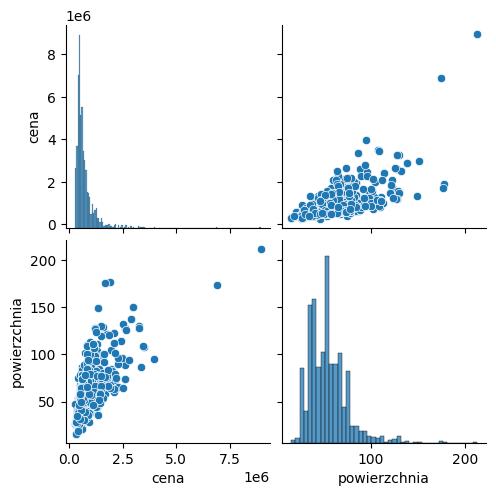

In [ ]:
sns.pairplot(df)

In [ ]:
def wspolczynniki_regresji(df):
    n = len(df)
    sum_x = df['powierzchnia'].sum()
    sum_y = df['cena'].sum()
    sum_xy = (df['powierzchnia'] * df['cena']).sum()
    sum_x_kw = (df['powierzchnia']**2).sum()

    a = (n * sum_xy - sum_x * sum_y) / (n * sum_x_kw - sum_x**2)
    b = (sum_y - a * sum_x) / n

    return a, b

In [ ]:
def przewidywanie_ceny(x, a, b):
    return a * x + b

In [ ]:
a, b = wspolczynniki_regresji(df)

In [ ]:
wartosc = float(input("Podaj metraz mieszkania: "))
przewidziane_ceny = przewidywanie_ceny(wartosc, a, b)

Podaj metraz mieszkania: 30


In [ ]:
print(f"Współczynniki regresji: a = {a}, b = {b}")
print("Przewidywana cena dla powierzchni ", wartosc ,f": {przewidziane_ceny}")

Współczynniki regresji: a = 17564.366446775708, b = -241074.15766684175
Przewidywana cena dla powierzchni  30.0 : 285856.83573642944


In [ ]:
x_range = range(int(df['powierzchnia'].min()), int(df['powierzchnia'].max()) + 1)
przewidziane_ceny = [przewidywanie_ceny(x, a, b) for x in x_range]

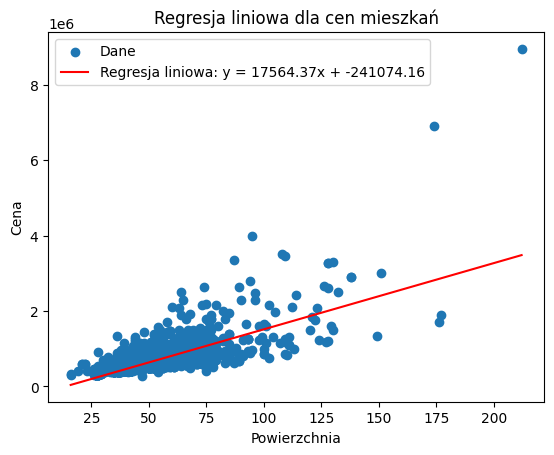

In [ ]:
plt.scatter(df['powierzchnia'], df['cena'], label='Dane')
plt.plot(x_range, przewidziane_ceny, color='red', label=f'Regresja liniowa: y = {a:.2f}x + {b:.2f}')
plt.xlabel('Powierzchnia')
plt.ylabel('Cena')
plt.legend()
plt.title('Regresja liniowa dla cen mieszkań')
plt.show()